## Trayendo datos

In [1]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-07-01 00:00:00"),
                  end=string2ts("2018-03-01 00:00:00"),
                  period=3600*4)
per = 0.85


## Parámetros vía stockstacks

In [2]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Creando estrategia ideal y separando en train y test 

In [25]:
from mldata import ml_data
from orders import orders
from profit import profit

df["ml_data"] = ml_data(df["close"],la=10, pl=False)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"],"ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"]})

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

train.tail()

Retorno de estrategia ideal: 42805.5813864


,cci,close,dma,ideal_w,kdjd,kdjj,kdjk,macd,macds,price,pricew,rsi,trix,volatility,volumen,vr,wr
date,,,,,,,,,,,,,,,,,
2018-01-22 20:00:00,53.594940,0.000124,-0.000005,1.0,36.514639,76.925898,49.985059,-0.000003,-0.000002,0.000124,0.000118,52.188082,-0.371616,True,1193.332722,36.812044,16.469120
2018-01-23 00:00:00,114.901357,0.000122,-0.000005,1.0,44.491601,92.353375,60.445526,-0.000002,-0.000002,0.000122,0.000122,50.230005,-0.355745,False,1108.483996,40.238765,18.633540
2018-01-23 04:00:00,57.322808,0.000120,-0.000004,1.0,50.316779,85.267846,61.967134,-0.000002,-0.000002,0.000120,0.000120,47.393459,-0.335701,True,542.760002,45.259988,34.989648
2018-01-23 08:00:00,54.807124,0.000120,-0.000004,1.0,54.630383,80.512011,63.257593,-0.000002,-0.000002,0.000120,0.000120,47.554950,-0.312800,False,558.331852,35.501154,34.161491
2018-01-23 12:00:00,176.899243,0.000125,-0.000003,1.0,59.638420,89.686640,69.654493,-0.000001,-0.000002,0.000125,0.000124,54.137682,-0.273059,True,1068.716270,45.374908,17.551705


## Importando modelos de clasificación

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

features = ["price","rsi","cci","macds","macd","wr","trix","vr"]

X, y = data[features], data["ideal_w"]

## Validación cruzada XGBoost 

### base_score

In [32]:
# tuneado de base_score

params = np.linspace(0.01, 0.99, 1000)
#params = np.logspace(-10, 0, 10)
xgb = XGBClassifier()

scores = list()
scores_std = list()

for bs in params:
    xgb.base_score = bs
    
    this_scores = cross_val_score(xgb, X, y, n_jobs=-1)
    
    # calculando promedio y std de las validaciones cruzadas
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    

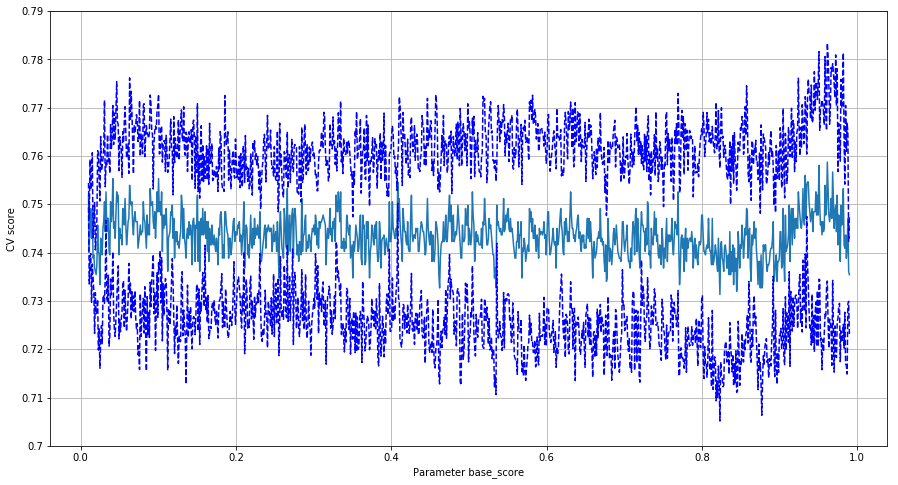

In [33]:
plt.plot(params, scores)
plt.plot(params, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(params, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter base_score')
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### n_estimators

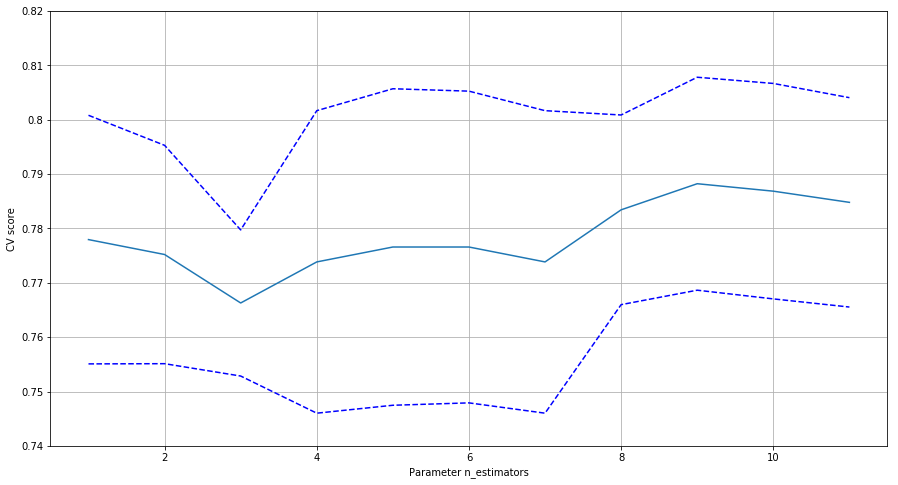

In [38]:
parameter = "n_estimators"
params = range(1,12)
#params = np.logspace(-10, 0, 10)
xgb = XGBClassifier()

scores = list()
scores_std = list()

for bs in params:
    xgb.n_estimators = bs
    
    this_scores = cross_val_score(xgb, X, y, n_jobs=-1)
    
    # calculando promedio y std de las validaciones cruzadas
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.plot(params, scores)
plt.plot(params, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(params, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### learning_rate

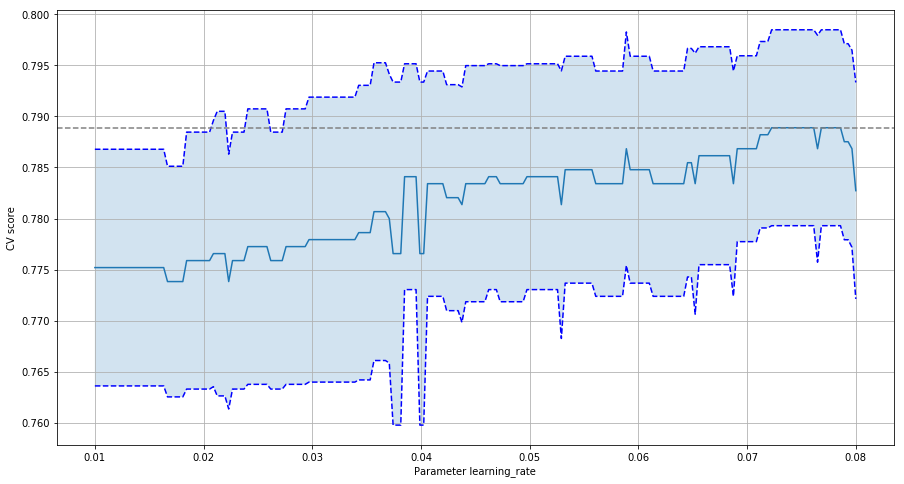

In [57]:
parameter = "learning_rate"
alphas = np.linspace(0.01, 0.08, 200)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### max_depth

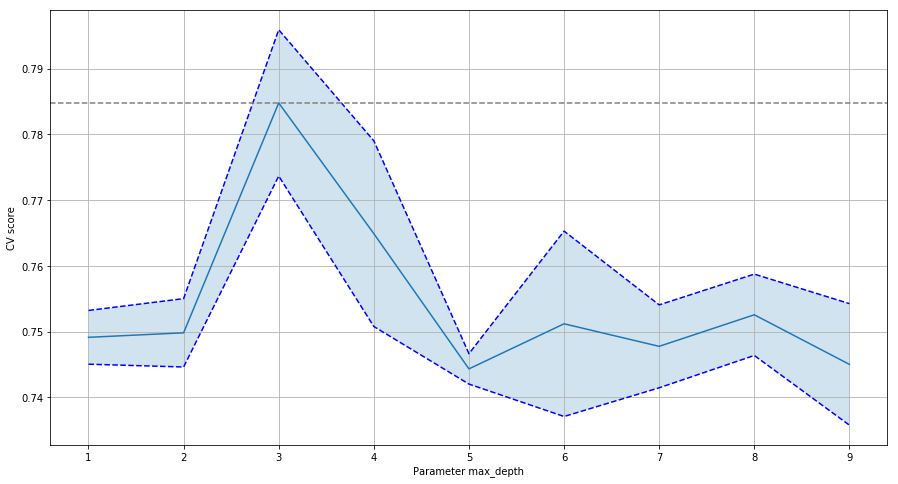

In [61]:
parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### gamma

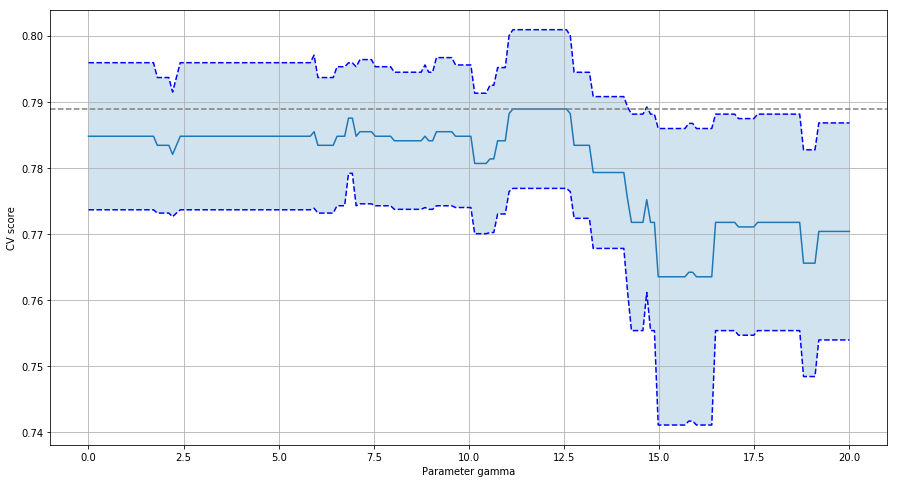

In [64]:
parameter = "gamma"
alphas = np.linspace(0, 20, 200)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

In [39]:
help(XGBClassifier())

Help on XGBClassifier in module xgboost.sklearn object:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |      Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a custom objective function to be used (see note below).
 |  booster: string
 |      Specify which booster to use: gbtree, gblinear or dart.
 |  nthread : int
 |      Number of parallel threads used to run xgboost.  (Deprecated, please use n_jobs)
 |  n_jobs : int
 |      Number of parallel threads used to run xgboost.  (replaces nthread)
 |  gamma : float
 |      Minimu